In [1]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from point import Point

Same pool of trials for all participants (static), with different shuffling (dynamic).

---

# Static Layout Pool
This refers to the generation of the layout pool, which will is the same for ALL participants.

## Generation

- Given N trials, we produce  N/2 pairs of layouts.
    - Between these pairs, we keep the same coordinates for the points, and the same order of navigation.
    - One of these pairs is the no-boundary-show, the other is the boundary-shown. The layout is rotated between these two.
    - Per layout, we have 5 objects and an ending location. The first object is also the starting location and might be asked.
    - We do not want any 2 objects to be too close to each other.
    - We do not want any path to be too short. We do not have an upper bound on the travel distance.
    - We want to to make sure that there is at least one object on both sides.

In [2]:
N_POINTS_LAYOUT = 6 # 5 objects, one of which is the starting location, and an ending location
N_LAYOUTS = 50 # generate this many layouts. each layout produces a pair (visible/invisible boundary)

# these are currently arbitrary units that we can scale up and down as needed
# w=5, l=10 represents a 1 by 2 rectangle room
WIDTH = 5 
LENGTH = 10

# this is the minimum distance any two objects (not a path) can have. 
# used to prevent objects appearing too close and confusing participants
MIN_DIST_OBJECTS = 1.5

# this is the minimum path distance. no subsequent object should appear closer than this.
# greater than MIN_DIST_OBJECTS because objects appearing too close also means they are visited too soon and not enough time to learn that object
MIN_DIST_PATH = 2.3

In [3]:
def generate_random_layout():
    return [Point.random_rect(WIDTH, LENGTH) for p in range(N_POINTS_LAYOUT)]

def has_valid_margin(p):
    buffer = 0.05
    x_lo = buffer * WIDTH
    x_hi = (1 - buffer) * WIDTH
    
    y_lo = buffer * LENGTH
    y_hi = (1 - buffer) * LENGTH
    
    border_lo = (LENGTH / 2) - LENGTH * buffer
    border_hi = (LENGTH / 2) + LENGTH * buffer
    
    bufferFromBoundary = (x_lo < p.x < x_hi) and (y_lo < p.y < y_hi)
    bufferFromBorder = not (border_lo < p.y < border_hi)
    
    return bufferFromBoundary and bufferFromBorder

def is_valid_layout(lay):
    
    # check all distance constraints, (dist between objects and path distances)
    for i in range(len(lay)):
        for j in range(i):
            # if these points are adjacent, check for path distance condition, otherwise object distance condition
            lower_bound = MIN_DIST_PATH if j == i - 1 else MIN_DIST_OBJECTS
            if lay[i].dist(lay[j]) <= lower_bound:
                return False
    
    # check that there is at least one object on each side
    # note that this checks for objects ONLY (that is; not the last point which is the ending/task location)
    objects_on_lower_side = sum([1 if l.y < LENGTH / 2 else 0 for l in lay[:N_POINTS_LAYOUT-1]])
    if not ( 1 <= objects_on_lower_side < N_POINTS_LAYOUT-1):
        # either 0 or N_POINTS_LAYOUT-1 on this side, which means the reverse for the other side. not valid!
        return False
    
    for p in lay:
        if not has_valid_margin(p):
            return False
    
    return True

def generate_valid_layout():
    candidate = generate_random_layout()
    c = 0
    while not is_valid_layout(candidate):
        c += 1
        if c == 1e5:
            print("can not find valid layout!")
            return None
        candidate = generate_random_layout()
    return candidate

In [4]:
layouts = []
for l in range(N_LAYOUTS):
    layouts.append(generate_valid_layout())

In [5]:
print(layouts)

[[P(0.8, 6.48), P(2.89, 3.28), P(3.64, 9.37), P(0.75, 3.23), P(2.61, 6.7), P(4.52, 0.53)], [P(1.09, 8.17), P(4.53, 0.59), P(2.53, 2.49), P(2.4, 7.01), P(0.84, 2.51), P(4.07, 8.73)], [P(4.06, 5.97), P(0.45, 5.94), P(3.37, 7.69), P(0.67, 1.79), P(3.41, 3.68), P(2.38, 1.43)], [P(1.39, 1.8), P(3.81, 6.31), P(0.34, 5.97), P(2.53, 3.33), P(4.56, 0.85), P(3.9, 7.81)], [P(4.56, 6.54), P(2.09, 5.92), P(4.67, 0.81), P(1.47, 0.98), P(4.18, 4.25), P(0.75, 3.84)], [P(3.11, 9.17), P(0.91, 2.37), P(2.66, 3.87), P(0.99, 8.52), P(4.69, 3.31), P(3.08, 0.66)], [P(0.52, 1.14), P(0.78, 6.52), P(4.74, 4.24), P(1.82, 7.78), P(3.91, 5.93), P(2.13, 2.71)], [P(2.78, 2.44), P(0.66, 8.89), P(0.91, 5.59), P(1.01, 2.0), P(4.45, 8.4), P(3.25, 6.42)], [P(3.44, 4.49), P(3.04, 7.01), P(2.42, 0.79), P(4.62, 6.26), P(0.56, 4.33), P(4.06, 2.01)], [P(1.6, 9.31), P(3.99, 6.27), P(4.11, 9.47), P(1.27, 6.51), P(4.21, 2.14), P(1.84, 0.87)], [P(3.66, 8.42), P(1.55, 2.52), P(4.29, 4.48), P(1.87, 5.55), P(4.72, 0.58), P(0.57, 6.6

## Checks
- We want to check for the following distributions:
    - Pointing ground-truths -> compare those in the same side and across the boundary.
    - How much they have traveled
    - Distances between any two objects
    
- And the following are nice sanity checks to have:
    - Plot of all layouts
    - Plot of all points

In [6]:
# Ground Truth for Pointing Tasks (GTPT)
gtpt_same = []
gtpt_cross = []

for lay in layouts:
    last = lay[-1]
    last_side = last.y < LENGTH / 2
    
    for obj in lay[:-1]:
        is_on_same_side = last_side == (obj.y < LENGTH / 2)
        dist = last.dist(obj)
        if is_on_same_side:
            gtpt_same.append(dist)
        else:
            gtpt_cross.append(dist)

gtpt_all = [gtpt_same, gtpt_cross]
print(len(gtpt_same), "same side; ", len(gtpt_cross), "across boundary")

118 same side;  132 across boundary


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


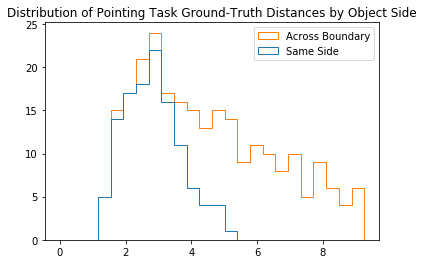

In [7]:
plt.hist(gtpt_all, bins = 24, range = [0, max(gtpt_same + gtpt_cross)] ,histtype='step', stacked=True, fill=False, label = ["Same Side", "Across Boundary"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Pointing Task Ground-Truth Distances by Object Side")
plt.show()

In [9]:
# Travel Distance (TD)
td_all = []

for lay in layouts:
    for i in range(len(lay) - 1):
        td_all.append(lay[i].dist(lay[i+1]))

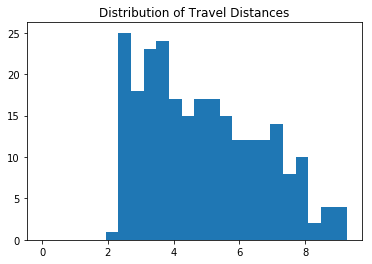

In [15]:
plt.hist(td_all, bins = 24, range = [0, max(td_all)])
plt.title("Distribution of Travel Distances")
plt.show()

In [21]:
# Object Distance (OD)
od_all = []

for lay in layouts:
    for i in range(len(lay)):
        for j in range(i):
            od_all.append(lay[i].dist(lay[j]))

print(f"{len(od_all)} object distances")

750 object distances


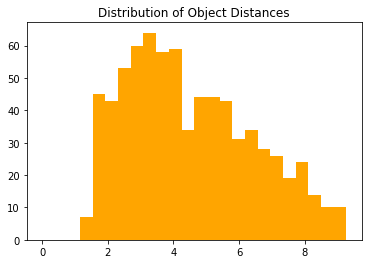

In [23]:
plt.hist(od_all, bins = 24, range = [0, max(od_all)], color = "orange")
plt.title("Distribution of Object Distances")
plt.show()

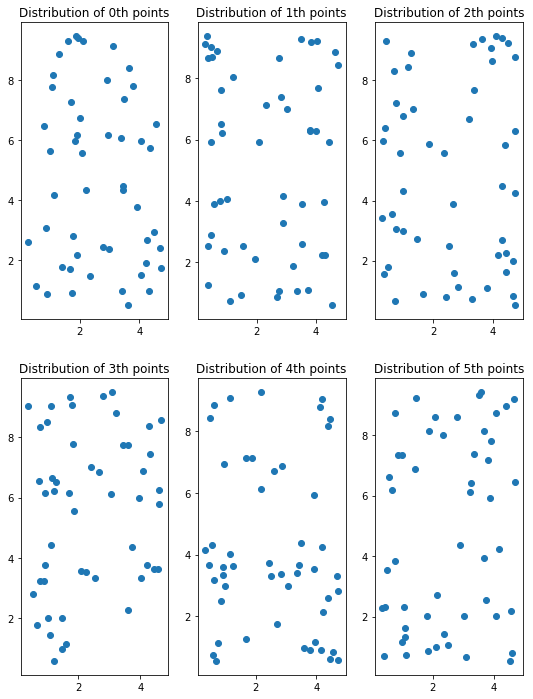

In [8]:
fig, axs = plt.subplots(2, 3, figsize = (9, 12))
for i in range(N_POINTS_LAYOUT):
    ith_ps = [layouts[j][i] for j in range(N_LAYOUTS)]
    xs, ys = [p.x for p in ith_ps], [p.y for p in ith_ps]
    axs[i//3, i%3].scatter(xs, ys)
    axs[i//3, i%3].set_title(f"Distribution of {i}th points")

# Dynamic Trial Shuffling
- We shuffle the N trials such that the boundary visibility alternates each time.

## Checks

- At least K = 5 trials between trials of the same pairing.
- We make sure that approx. half the pairs happen in A->B, and the other half happens in B->A
- We make sure that between adjacent pairs, the ending location and starting location is always opposite.
- We want to check the number of objects within the same cells across a sliding window of 5 trials.

# Objects
- 5 different shapes (circle, cube, cylinder, pyramid, star)
- 5 different colors from a color-blind-friendly palette.
-> 25 different combinations.

Any object generated must not have been in the last 10 shown object.